In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import lightning as L
import torch
import torch.nn as nn
from lit_llama import model
import random
from lit_llama import LLaMA, Tokenizer
from lit_llama.utils import EmptyInitOnDevice, lazy_load, llama_model_lookup

from datasets import load_dataset
from transformers import AutoTokenizer



/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import wandb

In [3]:
fabric = L.Fabric(devices=1)
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")
tokenizer = Tokenizer(tokenizer_path)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)



In [5]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)

for item in alpaca_json:
    if(len(item['input']) == 0):
        print(item)
        break

{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}


In [6]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)
'''
for item in alpaca_json:
    if(len(item['input']) == 0):
        item['input'] = ' '
  

'''

# Create tokenized j
squad_train = []
squad_test = []

for item in alpaca_json[:5176]:
    if(len(item['input']) == 0):
        squad_test.append(
            {
                'instruction': tokenizer.encode(item['instruction'], bos=True, eos=False, device=fabric.device),
                'input': tokenizer.encode(item['input'], bos=False, eos=False, device=fabric.device),
                'output':tokenizer.encode(item['output'], bos=False, eos=True, device=fabric.device)
            }
        )


for item in alpaca_json[5176:]:
    if(len(item['input']) == 0):
        squad_train.append(
            {
                'instruction': tokenizer.encode(item['instruction'], bos=True, eos=False, device=fabric.device),
                'input': tokenizer.encode(item['input'], bos=False, eos=False, device=fabric.device),
                'output':tokenizer.encode(item['output'], bos=False, eos=True, device=fabric.device)
            }
        )

In [7]:
print(len(squad_train))
print(len(squad_test))

29515
3088


In [8]:
def get_single_example(dataset, index=None):
    if(index is None):
        index = random.sample(range(len(dataset)), k=1)[0]
    # IST
    IST = IST_generator(LLamaModel(dataset[index]['instruction'].unsqueeze(0).to(fabric.device))[1])[:,-1,:]

    # Question
    question = LLamaModel.transformer.wte(dataset[index]['input'].unsqueeze(0).to(fabric.device)).squeeze()

    # Answer fragment
    answer_len = dataset[index]['output'].size(0)
    trunc_len = random.randint(0,answer_len-1)
    #print(answer_len)
    #print(trunc_len)

    truncated_answer = dataset[index]['output'][:trunc_len]
    truncated_answer = LLamaModel.transformer.wte(truncated_answer)
    
    target_tokens = torch.cat([dataset[index]['input'], dataset[index]['output'][:trunc_len+1]])
    #print(tokenizer.decode(target_tokens))

    if(question.dim() == 1):
        question = question.unsqueeze(0)

    if(truncated_answer.dim() == 1):
        truncated_answer = truncated_answer.unsqueeze(0)

    llama_input = torch.cat([IST,question,truncated_answer])
    return llama_input.unsqueeze(0), target_tokens.type(torch.LongTensor).unsqueeze(0)
    
    

In [9]:
train_losses = []
test_losses = []

In [10]:
checkpoint_path: Path = Path("checkpoints/lit-llama/7B/lit-llama.pth")
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")


def load_LLaMA(checkpoint_path):
    with lazy_load(checkpoint_path) as checkpoint:
        name = llama_model_lookup(checkpoint)

        with EmptyInitOnDevice(
                device=fabric.device, dtype=dtype, quantization_mode=None # We won't quantize the weights
        ):
            model = LLaMA.from_name(name)

        model.load_state_dict(checkpoint)
    return model

In [11]:

dtype = torch.bfloat16 if fabric.device.type == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

LLaMA_config = model.LLaMAConfig.from_name('7B')
print('Loading models...')
# Load the LLaMa model and the IST generator (also a LLaMA model)
LLamaModel = load_LLaMA(checkpoint_path).to(fabric.device)
#LLamaModel = LLaMA(LLaMA_config).to(fabric.device)
print('Finished loading the first model')
print('Finished loading models')
tokenizer = Tokenizer(tokenizer_path)

IST_schemes = ['vanilla', 'last 4', '2nd to last', 'all layers']
scheme_losses = {}

IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)
IST_generator = IST_generator.to(fabric.device)

for param in LLamaModel.parameters():
    param.requires_grad=False

Loading models...
Finished loading the first model
Finished loading models


In [12]:
IST_generator = model.Block(LLaMA_config)
IST_generator = IST_generator.to(fabric.device)

In [13]:
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-5)

In [14]:
learning_rate = 1e-5
batch_size=32
trainset_size=4000
testset_size=1000

config = {
    'lr': learning_rate,
    'batch_size': batch_size,
    'trainset_size': trainset_size,
    'testset_size':testset_size,
}

In [15]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrew-zeng (smalllanguagemodels). Use `wandb login --relogin` to force relogin


True

In [16]:
# init wandb
wandb.init(
    project='Alpaca instruction tuning',
    config=config,
    name="Training the IST generator on Alpaca samples with empty input"
)

In [17]:
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)

In [18]:
loss_fn = nn.CrossEntropyLoss()
for param in LLamaModel.parameters():
    param.requires_grad=False

batch_size=32

LLamaModel.eval()
for epoch in range(1):

    indices = list(range(len(squad_train)))
    random.shuffle(indices)
    epoch_train_loss = 0

    while(len(indices) >= batch_size):
        batch_indices = indices[:batch_size]
        indices = indices[batch_size:]
        batch_loss = 0

        IST_generator.train()
        optimizer.zero_grad()
        for i in range(batch_size):
            input, target = get_single_example(squad_train, index=batch_indices[i])
            llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
            loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))
            loss.backward()
            batch_loss += loss.item()
            del llama_output

        batch_loss /= batch_size

        optimizer.step()
        train_losses.append(batch_loss)
        epoch_train_loss += batch_loss

        # validation:
        IST_generator.eval()
        with torch.no_grad():
            batch_loss = 0
            for i in range(batch_size):
                input, target = get_single_example(squad_test)
                llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
                loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))
                del llama_output
                batch_loss += loss.item()
            batch_loss /= batch_size

            test_losses.append(batch_loss)
            
        print(f'epoch {epoch}, train loss = {train_losses[-1]}, validation loss={test_losses[-1]}')
        wandb.log({'batch train loss':train_losses[-1], 'batch validation loss':test_losses[-1]})

    # perform validation on entire validation set
    with torch.no_grad():
        batch_loss = 0
        for i in range(1000):
            input, target = get_single_example(squad_test, i)
            llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
            loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))
            del llama_output
            batch_loss += loss.item()
        batch_loss /= 1000

    # wandb.log({'epoch train loss':epoch_train_loss, 'epoch validation loss':batch_loss})


        

epoch 0, train loss = 5.7236328125, validation loss=2.375732421875
epoch 0, train loss = 3.821533203125, validation loss=2.591064453125
epoch 0, train loss = 2.6571044921875, validation loss=3.30908203125
epoch 0, train loss = 2.62548828125, validation loss=3.2879638671875
epoch 0, train loss = 2.8255615234375, validation loss=2.4464111328125
epoch 0, train loss = 2.501708984375, validation loss=2.642333984375
epoch 0, train loss = 2.522705078125, validation loss=2.10302734375
epoch 0, train loss = 2.0941162109375, validation loss=2.79296875
epoch 0, train loss = 2.6201171875, validation loss=2.7679443359375
epoch 0, train loss = 2.658935546875, validation loss=2.4058837890625
epoch 0, train loss = 2.185791015625, validation loss=2.31787109375
epoch 0, train loss = 2.429443359375, validation loss=2.2755126953125
epoch 0, train loss = 1.9488525390625, validation loss=2.341064453125
epoch 0, train loss = 2.5023193359375, validation loss=2.442626953125
epoch 0, train loss = 2.218872070312

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:23                                                                                   │
│                                                                                                  │
│   20 │   │   optimizer.zero_grad()                                                               │
│   21 │   │   for i in range(batch_size):                                                         │
│   22 │   │   │   input, target = get_single_example(squad_train, index=batch_indices[i])         │
│ ❱ 23 │   │   │   llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]     │
│   24 │   │   │   loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to    │
│   25 │   │   │   loss.backward()                                                                 │
│   26 │   │   │   batch_loss += loss.item()                                                       │
│                                                                                                  │
│ /home/andrew/Documents/lit-llama/lit_llama/model.py:110 in forward_embeddings                    │
│                                                                                                  │
│   107 │   │   │   x = torch.cat((internal_state_tokens.reshape(1,1,-1).to(embeddings.device),    │
│   108 │   │                                                                                      │
│   109 │   │   for block in self.transformer.h:                                                   │
│ ❱ 110 │   │   │   x = block(x)                                                                   │
│   111 │   │   x = self.transformer.ln_f(x)                                                       │
│   112 │   │                                                                                      │
│   113 │   │   logits = self.lm_head(x)  # (b, t, vocab_size)                                     │
│                                                                                                  │
│ /home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl   │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/andrew/Documents/lit-llama/lit_llama/model.py:138 in forward                               │
│                                                                                                  │
│   135 │                                                                                          │
│   136 │                                                                                          │
│   137 │   def forward(self, x: torch.Tensor) -> torch.Tensor:                                    │
│ ❱ 138 │   │   x = x + self.attn(self.rms_1(x))                                                   │
│   139 │   │   x = x + self.mlp(self.rms_2(x))                                                    │
│   140 │   │   return x                                                                           │
│   141                                                      

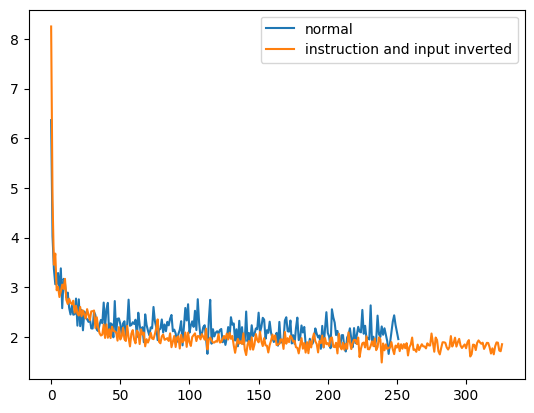

In [ ]:
plt.plot(train_losses[:252], label='normal')
plt.plot(train_losses[252:], label='instruction and input inverted')
plt.legend()
plt.show()


In [ ]:
def get_IST(string):
    tokens = tokenizer.encode(string).unsqueeze(0).type(torch.LongTensor).to(fabric.device)
    x = LLamaModel(tokens)[1]
    x = IST_generator(x)
    return x[:,-1,:]

In [ ]:
def generate(model, tokenizer, prompt, IST=None, max_new_tokens=200):
  
    generated = ''
    tokenized_input = tokenizer.encode(prompt).to(fabric.device)
    with torch.no_grad():

        for _ in range(max_new_tokens):
            last_logits = model(tokenized_input.unsqueeze(0), IST.type(torch.bfloat16))[0][:,-1,:]
            new_token = torch.argmax(last_logits, dim=1)
            if(new_token == 2 and _ > 0): #eos
                break
            generated += tokenizer.decode(new_token)
            tokenized_input = torch.cat([tokenized_input, new_token])

    return tokenized_input, tokenizer.decode(tokenized_input)[len(prompt)+1:]

In [ ]:
out = generate(LLamaModel, tokenizer, prompt="Country: Egypt", IST=get_IST("Write a story about a young boy visiting a foreign country."))

In [ ]:
out = generate(LLamaModel, tokenizer, prompt="Create a news headline for a story about a celebrity who just released a book.", IST=get_IST("Tom Hanks"))

In [ ]:
out[1]

'"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases New Book"\n"Celebrity Author Releases'

In [ ]:
out = generate(LLamaModel, tokenizer, squad['train'][0]['question'], IST=get_IST(squad['train'][0]['context']))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 out = generate(LLamaModel, tokenizer, squad['train'][0]['question'], IST=get_IST(squad['     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'squad' is not defined

In [ ]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)


Found cached dataset squad (/home/andrew/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


In [ ]:
alpaca_json[0]

{'instruction': 'Give three tips for staying healthy.',
 'input': ' ',
 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}

In [ ]:
squad['train'][10]

{'id': '56bed07e3aeaaa14008c94a9',
 'title': 'Beyoncé',
 'context': "Beyoncé has worked with Pepsi since 2002, and in 2004 appeared in a Gladiator-themed commercial with Britney Spears, Pink, and Enrique Iglesias. In 2012, Beyoncé signed a $50 million deal to endorse Pepsi. The Center for Science in the Public Interest (CSPINET) wrote Beyoncé an open letter asking her to reconsider the deal because of the unhealthiness of the product and to donate the proceeds to a medical organisation. Nevertheless, NetBase found that Beyoncé's campaign was the most talked about endorsement in April 2013, with a 70 per cent positive audience response to the commercial and print ads.",
 'question': 'Which soda company has Beyonce partnered with since 2002?',
 'answers': {'text': ['Pepsi'], 'answer_start': [24]}}

In [ ]:
IST_generator.load_state_dict(torch.load("new_instructtunedweights_4.pt"))

<All keys matched successfully>

In [ ]:
squad_test[10]['input'].shape[0]



1

In [ ]:
with torch.no_grad():
    empty_loss = 0
    nonempty_loss = 0

    for i in range(1000):
        input, target = get_single_example(squad_test, i)
        llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
        loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))

        if(squad_test[i]['input'].shape[0] == 1):
            empty_loss += loss.item()
        else:
            nonempty_loss += loss.item()

print(f'Empty: {empty_loss}\nNonempty: {nonempty_loss}')    

Empty: 855.9619140625
 Nonempty: 761.69921875


In [ ]:
len(squad_train)

46584

In [ ]:
if(squad_train[i]['input'][0] == 259 and squad_train[i]['input'].shape[0] == 1):
    print(1)

1


In [ ]:
with torch.no_grad():
    empty_loss = 0
    nonempty_loss = 0

    for i in range(1000):
        input, target = get_single_example(squad_train, i)
        llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
        loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))

        if(squad_train[i]['input'][0] == 259 and squad_train[i]['input'].shape[0] == 1):
            empty_loss += loss.item()
        else:
            nonempty_loss += loss.item()

print(f'Empty: {empty_loss}\nNonempty: {nonempty_loss}')    

Empty: 816.0869140625
Nonempty: 976.6796875


In [ ]:
out[1]

'Wojciech Żywny'